# FIN3080 Assignment 2

> **Author Information**:
>- Name: `Weiyuan Xu`
>- StdID: `120090888`

## 0. Preparations

### 0-1. Load in packages

In [197]:
import pandas as pd
import numpy as np
import datetime as dt
import math

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
import statsmodels.api as sm

from mpl_toolkits.mplot3d import Axes3D

### 0-2. Load in datasets

#### 0-2-1. Read datasets

> **Data Resources**:
>- Data Service Platform: `CSMAR`
>- Databases: `CSMAR_China Stock Market Series` & `CSMAR_China Listed Firms Research Series`

**Detailed Selection Process of Data Tables Used:**
- table_one: China Stock Market Series -> Stock Trading -> Individual Stock Trading -> Monthly Stock Price & Returns
- table_two: China Stock Market Series -> Stock Market Derivative Index -> Risk Factor -> Risk Factor Indices of Individual Stocks (250- Trading Day Rolling Samples)
- table_three: China Listed Firms Research Series -> Financial Statements -> Balance Sheet
- table_four: China Listed Firms Research Series -> Financial Indicators -> Earning Capacity

***Note: All above tables only include the information of A-shares with the filtering function of CSMAR***

In [198]:
table_one = pd.read_csv('1.csv')
table_two = pd.read_csv('2.csv')
table_three = pd.read_csv('3.csv')
table_four = pd.read_csv('4.csv')

#### 0-2-2. Preliminary processing and interpret for individual datasets

**Variables in Table 1:**
- Monthly Return
- Market Type
- Market Value

**Interpretation of picking corresponding tickers:**
- Monthly Return: Use ***Monthly Return with Cash Dividend Reinvested***.
- Market Type: Use ***Monthly Type*** to classify different markets.
- Market Value: Use ***Total Market Value*** since these two concepts are equivalent.

In [199]:
table_one = table_one.rename(columns={"Stkcd": "Stock_Code", "Trdmnt": "Date", "Msmvttl": "Market Value", "Mretwd": "Monthly_Return", "Markettype": "Market_Type"})
table_one.head()

Stock_Code     Date  Market Value  Monthly_Return  Market_Type
0           1  2009-12   75679420.78        0.004534            4
1           1  2010-01   67387912.64       -0.109561            4
2           1  2010-02   69716987.96        0.034562            4
3           1  2010-03   72046063.28        0.033408            4
4           1  2010-04   63847718.15       -0.113793            4

***Market Type Extraction***
- Main Board: ***Market Type*** = 1, 4, 64

***Remarks:*** 

Here, **Market Value** should time 1000 because the unit for this ticker in the database is **CNY1000**.

In [200]:
table_one = table_one.loc[table_one["Market_Type"].isin([1, 4, 64])]
table_one = table_one.loc[:,["Stock_Code", "Date", "Market Value", "Monthly_Return"]]
table_one["Market Value"] = table_one["Market Value"] * 1000
table_one.head()

Stock_Code     Date  Market Value  Monthly_Return
0           1  2009-12  7.567942e+10        0.004534
1           1  2010-01  6.738791e+10       -0.109561
2           1  2010-02  6.971699e+10        0.034562
3           1  2010-03  7.204606e+10        0.033408
4           1  2010-04  6.384772e+10       -0.113793

**Variables in Table 2:**
- Daily Stock Volatility

**Interpretation of picking corresponding tickers:**
- Daily Stock Volatility: Use ***Return Volatility*** since these two concepts are equivalent.

In [201]:
table_two = table_two.rename(columns={"Symbol": "Stock_Code", "TradingDate": "Date", "Volatility": "Return Volatility"})
table_two.head()

Stock_Code        Date  Return Volatility
0           1  2010-01-04           0.480086
1           1  2010-01-05           0.478539
2           1  2010-01-06           0.473399
3           1  2010-01-07           0.471819
4           1  2010-01-08           0.468114

**Variables in Table 3:**
- Total Asset 
- Total Liability

**Interpretation of picking corresponding tickers:**
- Total Asset: Use ***Total Asset*** since these two concepts are equivalent.
- Total Liability: Use ***Total Liability*** since these two concepts are equivalent.

***Remarks:*** 

When accessing data from CSMAR, we set the condition **"Statement Type = Consolidated Statements"** since:

Consolidated statements reflect the financial position and operating results of the entire enterprise group; 
The parent statement only reflects the business situation of the parent company, and its right to control the entire enterprise group is actually reflected in the long-term asset account as an investment. 
In the process of merging the statements of the parent company and the subsidiary company, the parent company's investment in the subsidiary company, internal purchase and sale, creditor's rights and debts are offset.

In [202]:
table_three = table_three.rename(columns={"Stkcd": "Stock_Code", "Accper": "Date", "A001000000": "Total Asset", "A002000000": "Total Liability"})
table_three = table_three.loc[:,["Stock_Code", "Date", "Total Asset", "Total Liability"]]
table_three.head()

Stock_Code        Date   Total Asset  Total Liability
0           1  2009-09-30  5.542647e+11     5.351762e+11
1           1  2009-12-31  5.878110e+11     5.673414e+11
2           1  2010-01-01  5.878110e+11     5.673414e+11
3           1  2010-03-31  6.199276e+11     5.978178e+11
4           1  2010-06-30  6.243982e+11     5.939771e+11

**Variable in Table 4:**
- Return on Equity (ROE)

**Interpretation of picking corresponding ticker:**
- Return on Equity (ROE): Use ***Return on Equity - TTM*** since TTM-version ROE provides a more up-to-date picture of a company's ROE.

***Remarks:*** 

When accessing data from CSMAR, we set the condition **"Statement Type = Consolidated Statements"** since:

Consolidated statements reflect the financial position and operating results of the entire enterprise group; 
The parent statement only reflects the business situation of the parent company, and its right to control the entire enterprise group is actually reflected in the long-term asset account as an investment. 
In the process of merging the statements of the parent company and the subsidiary company, the parent company's investment in the subsidiary company, internal purchase and sale, creditor's rights and debts are offset.

In [203]:
table_four = table_four.rename(columns={"Stkcd": "Stock_Code", "Accper": "Date", "F050504C": "ROE"})
table_four = table_four.loc[:,["Stock_Code", "Date", "ROE"]]
table_four.head()

Stock_Code        Date       ROE
0           1  1991-12-31       NaN
1           1  1992-12-31       NaN
2           1  1993-06-30       NaN
3           1  1993-12-31  0.315094
4           1  1994-06-30       NaN

### 0-3. Construction of monthly P/B Ratio for all firms in the mainboard from Jan. 2010 to Dec. 2022

Monthly P/B = Monthly market value / (Total asset - Total liability)

#### 0-3-1. Compute total equity

In [204]:
table_three["Total Equity"] = table_three["Total Asset"] - table_three["Total Liability"]
table_three.head()

Stock_Code        Date   Total Asset  Total Liability  Total Equity
0           1  2009-09-30  5.542647e+11     5.351762e+11  1.908844e+10
1           1  2009-12-31  5.878110e+11     5.673414e+11  2.046961e+10
2           1  2010-01-01  5.878110e+11     5.673414e+11  2.046961e+10
3           1  2010-03-31  6.199276e+11     5.978178e+11  2.210983e+10
4           1  2010-06-30  6.243982e+11     5.939771e+11  3.042111e+10

#### 0-3-2. Merge two dataframes

##### 0-3-2-1. Extract sub dataframes

In [205]:
df_temp_sub1 = table_one.loc[:,["Stock_Code", "Date", "Market Value"]]
df_temp_sub1['Date'] = pd.to_datetime(df_temp_sub1['Date']).dt.to_period('M')
df_temp_sub1.head()

Stock_Code     Date  Market Value
0           1  2009-12  7.567942e+10
1           1  2010-01  6.738791e+10
2           1  2010-02  6.971699e+10
3           1  2010-03  7.204606e+10
4           1  2010-04  6.384772e+10

In [206]:
df_temp_sub2 = table_three.loc[:,["Stock_Code", "Date", "Total Equity"]]
df_temp_sub2['Date'] = pd.to_datetime(df_temp_sub2['Date']).dt.to_period('M')
df_temp_sub2.head()

Stock_Code     Date  Total Equity
0           1  2009-09  1.908844e+10
1           1  2009-12  2.046961e+10
2           1  2010-01  2.046961e+10
3           1  2010-03  2.210983e+10
4           1  2010-06  3.042111e+10

##### 0-3-2-2. Merge sub dataframes

In [207]:
df_PB = pd.merge(df_temp_sub1, df_temp_sub2, on = ['Stock_Code', 'Date'], how = 'left')
df_PB.head()

Stock_Code     Date  Market Value  Total Equity
0           1  2009-12  7.567942e+10  2.046961e+10
1           1  2010-01  6.738791e+10  2.046961e+10
2           1  2010-02  6.971699e+10           NaN
3           1  2010-03  7.204606e+10  2.210983e+10
4           1  2010-04  6.384772e+10           NaN

##### 0-3-2-3. Convert quarterly total equity into monthly total equity

***Conversion Method***:

Replace the NaN value in the Total Equity with the **previous record**.

In [208]:
df_PB["Total Equity"].fillna(method = 'ffill', inplace = True)
df_PB.head()

Stock_Code     Date  Market Value  Total Equity
0           1  2009-12  7.567942e+10  2.046961e+10
1           1  2010-01  6.738791e+10  2.046961e+10
2           1  2010-02  6.971699e+10  2.046961e+10
3           1  2010-03  7.204606e+10  2.210983e+10
4           1  2010-04  6.384772e+10  2.210983e+10

#### 0-3-3. Compute monthly P/B Ratio from Jan. 2010 to Dec. 2022

In [209]:
df_PB["P/B_Ratio"] = df_PB["Market Value"] / df_PB["Total Equity"]
df_PB = df_PB.loc[:, ["Stock_Code", "Date", "P/B_Ratio"]]
df_PB = df_PB.loc[(df_PB['Date'] >= '2010-01') & (df_PB['Date'] <= '2022-12')]
df_PB.head()

Stock_Code     Date  P/B_Ratio
1           1  2010-01   3.292096
2           1  2010-02   3.405878
3           1  2010-03   3.258554
4           1  2010-04   2.887753
5           1  2010-05   2.459366

## Problem 1

### 1-1. Problem 1-1: Regress the P/B Ratio on ROE and Stock Volatility as of 2010Q4

#### 1-1-1. Extract the P/B Ratio, ROE, Stock Volatility in 2010Q4

***Extraction Method***:

Using the record in **2010-12 (For Monthly Record)** / on **2010-12-31 (For Daily Record)** since ROE is quarterly, which means ROE is computed until the end of each quarter in quarterly report.

In [210]:
df_PB_p1 = df_PB.loc[(df_PB['Date'] == '2010-12')]
df_PB_p1.head()

Stock_Code     Date  P/B_Ratio
10            1  2010-12   1.657604
167           2  2010-12   1.457725
316           4  2010-12   7.824707
466           5  2010-12   4.968947
608           6  2010-12   2.072690

In [211]:
df_ROE = table_four.loc[(table_four['Date'] == '2010-12-31')]
df_ROE.head()

Stock_Code        Date       ROE
55            1  2010-12-31  0.234177
156           2  2010-12-31  0.176802
276           4  2010-12-31  0.184460
376           5  2010-12-31 -0.006426
476           6  2010-12-31  0.209026

***Remarks:*** 

Here, **Return Volatility** should be divided by 2 because we are to convert the annual one into the quarterly one.

In [212]:
df_Volatility = table_two.loc[(table_two['Date'] == '2010-12-31')]
df_Volatility["Return Volatility"] = df_Volatility["Return Volatility"] / 2
df_Volatility.head()

/var/folders/sm/7tp7vpvj6hd2ttv98tx891kr0000gn/T/ipykernel_15176/4091654002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Volatility["Return Volatility"] = df_Volatility["Return Volatility"] / 2


Stock_Code        Date  Return Volatility
191            1  2010-12-31           0.187538
431            2  2010-12-31           0.180489
642            4  2010-12-31           0.191059
882            5  2010-12-31           0.204846
1121           6  2010-12-31           0.251204

In [213]:
df_1 = pd.merge(pd.merge(df_PB_p1, df_ROE, on = ['Stock_Code'], how = 'left'), df_Volatility, on = ['Stock_Code'], how = 'left')
df_1 = df_1.loc[:, ["Stock_Code", "P/B_Ratio", "ROE", "Return Volatility"]]
df_1.head()

Stock_Code  P/B_Ratio       ROE  Return Volatility
0           1   1.657604  0.234177           0.187538
1           2   1.457725  0.176802           0.180489
2           4   7.824707  0.184460           0.191059
3           5   4.968947 -0.006426           0.204846
4           6   2.072690  0.209026           0.251204

***Remarks:*** 

Here, we filter out the stocks with **Total Equity <= 0**, since the firms with **Total Equity <= 0** have gone bankrupt.

In [214]:
df_1 = df_1.loc[df_1["P/B_Ratio"] > 0]

#### 1-1-2. Data cleaning for regression

#### 1-1-2-1. Remove outliers

**Observation**

By plotting the distribution of P/B_Ratio(y), ROE(x1) and Stock Volatility(x2), it is well noticed that **there are some outliers in the P/B_Ratio and ROE (particularly on the right hand side)**, in order to get a more robust model, **we need to remove outliers for P/B_Ratio and ROE** before implementing regression.

**Outliers Removal Criterion**

IQR = 3rd Quantile - 1st Quantile;
- Left-outlier boundary = Q1 - 1.5 * IQR;
- Right-outlier boundary = Q3 + 1.5 * IQR.

<AxesSubplot:ylabel='Frequency'>

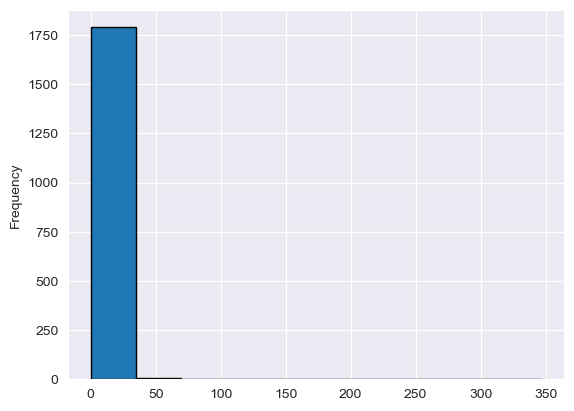

In [215]:
df_1["P/B_Ratio"].plot(kind = 'hist', edgecolor = 'black')

<AxesSubplot:ylabel='Frequency'>

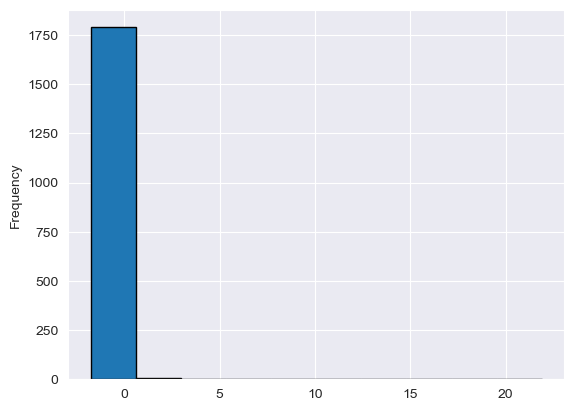

In [216]:
df_1["ROE"].plot(kind = 'hist', edgecolor = 'black')

<AxesSubplot:ylabel='Frequency'>

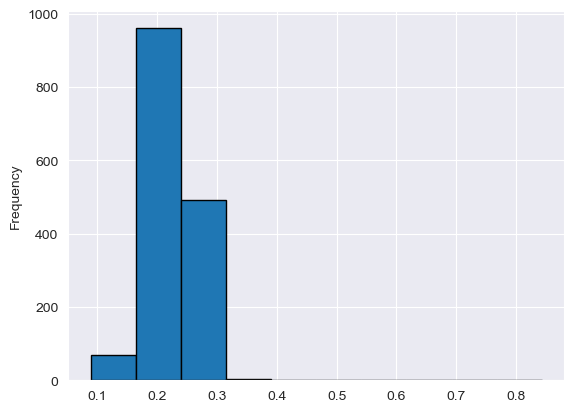

In [217]:
df_1["Return Volatility"].plot(kind = 'hist', edgecolor = 'black')

In [218]:
df_1.shape

(1802, 4)

In [219]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1 
    low  = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    df_out = df_in.loc[(df_in[col_name] > low) & (df_in[col_name] < high)]
    return df_out

In [220]:
df_1 = remove_outlier(df_1, "P/B_Ratio")
df_1 = remove_outlier(df_1, "ROE")
# df_1 = remove_outlier(df_1, "Return Volatility")

In [221]:
df_1.shape

(1567, 4)

<AxesSubplot:ylabel='Frequency'>

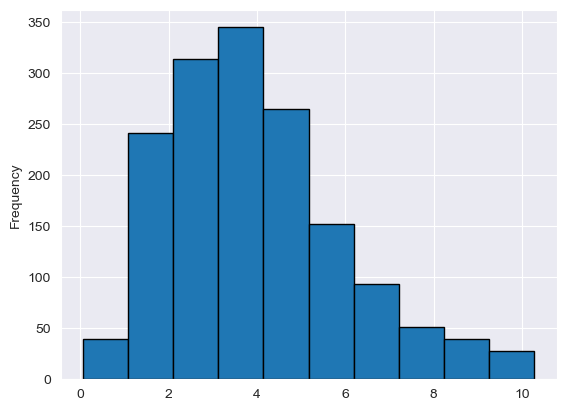

In [222]:
df_1["P/B_Ratio"].plot(kind = 'hist', edgecolor = 'black')

<AxesSubplot:ylabel='Frequency'>

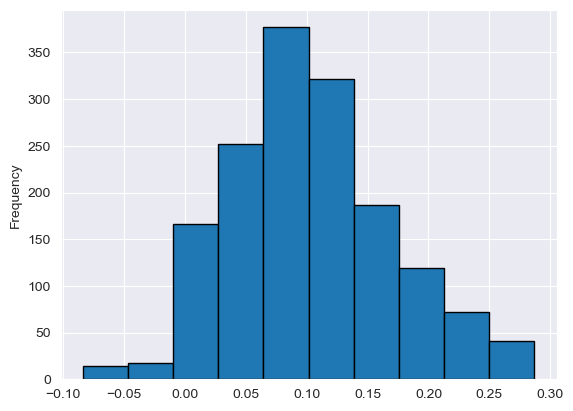

In [223]:
df_1["ROE"].plot(kind = 'hist', edgecolor = 'black')

<AxesSubplot:ylabel='Frequency'>

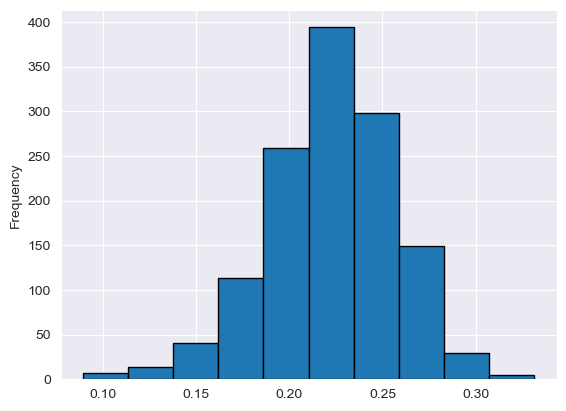

In [224]:
df_1["Return Volatility"].plot(kind = 'hist', edgecolor = 'black')

**Observation**

By plotting the distribution of P/B_Ratio(y), ROE(x1) and Stock Volatility(x2) again, it is well noticed that the distributions now seem better (closer to normal distribution) aftering dealing with outliers, then we implement Multiple Linear Regression to capture the relationship.

#### 1-1-3. Run the cross-sectional regression

##### 1-1-3-1. Regression function expression

In [225]:
df_1 = df_1.dropna()
X = df_1[['ROE', 'Return Volatility']]
y = df_1['P/B_Ratio']
model.fit(X, y)

LinearRegression()

In [226]:
model.intercept_

-2.1009198889502563

In [227]:
model.coef_

array([ 4.11136805, 25.19690315])

***Regression Equation***:

$$\hat{P/B} = -2.1009198889502563 + 4.11136805*ROE + 25.19690315*Volatility$$

##### 1-1-3-2. More inference statistics results

In [228]:
model = LinearRegression()
model.fit(X, y)

X = sm.add_constant(X)

ols_model = sm.OLS(y, X).fit()

ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              P/B_Ratio   R-squared:                       0.196
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     159.1
Date:                Wed, 22 Mar 2023   Prob (F-statistic):           1.47e-62
Time:                        01:43:25   Log-Likelihood:                -2648.3
No. Observations:                1309   AIC:                             5303.
Df Residuals:                    1306   BIC:                             5318.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.1009      0.342     -6.141      0.000      -2.772      -1.430
ROE                   4.1114      0.728      5.650      0.000       2.684       5.539
Return Volatility    25.1969      1.481     17.008      0.000      22.291      28.103
==============================================================================
Omnibus:                      149.632   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.214
Skew:                           0.904   Prob(JB):                     1.23e-44
Kurtosis:                       3.660   Cond. No.                         30.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Observation**

It is well-noticed that p-values for three coefficients in our regression model are all 0 (<0.001), which means my model is convincing.

#### 1-1-4. Visualize the regression result

In [229]:
# Data Preparation
X = df_1[['ROE', 'Return Volatility']].values.reshape(-1,2)
Y = df_1['P/B_Ratio']
x = X[:, 0]
y = X[:, 1]
z = Y

x_pred = np.linspace(-0.1, 0.5, 30)   
y_pred = np.linspace(0.1, 0.6, 30)  
xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
model = model.fit(X, Y)
predicted = model.predict(model_viz)
r2 = model.score(X, Y)

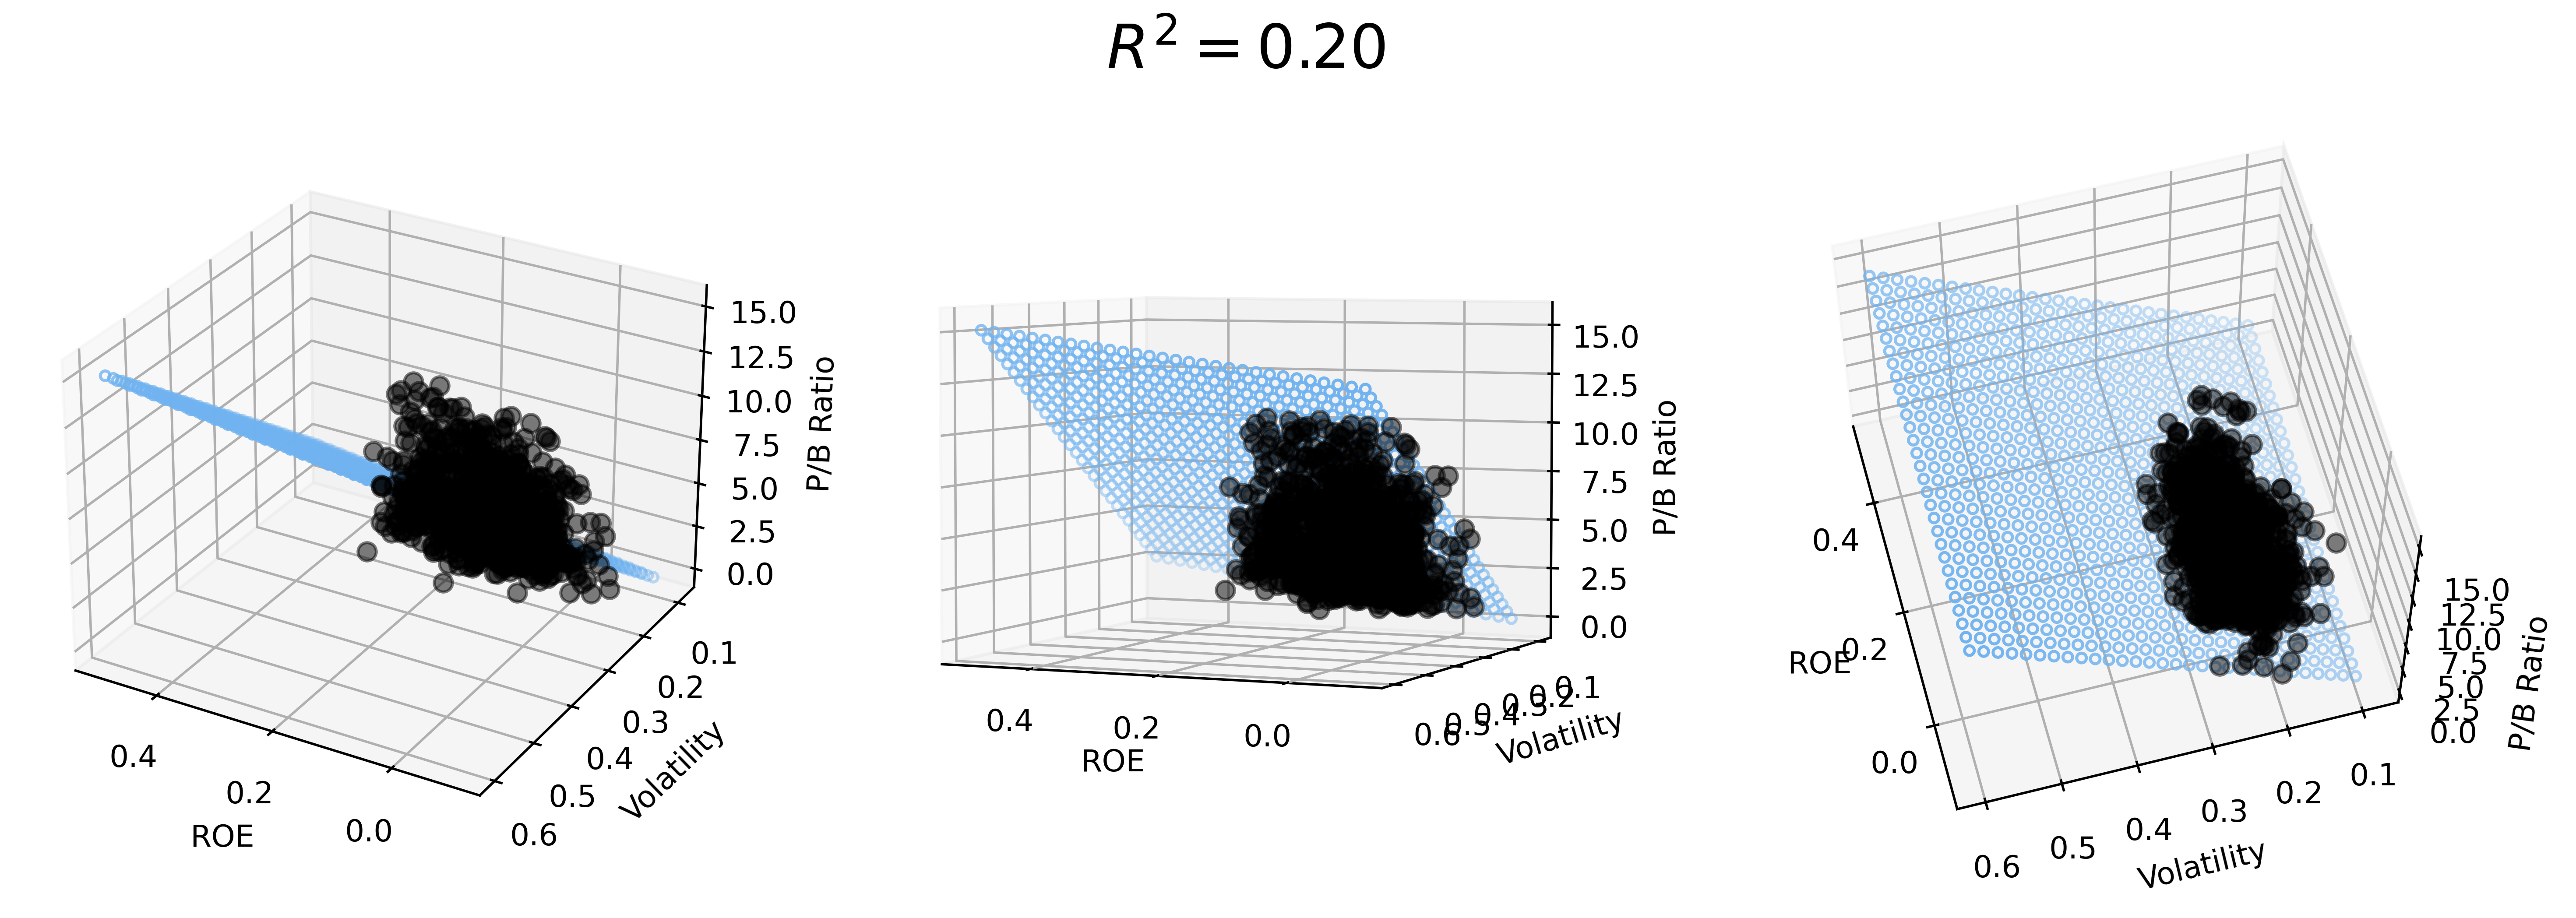

In [230]:
# Data Visualization
plt.style.use('default')

fig = plt.figure(figsize=(12, 4), dpi = 500)

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
    ax.scatter(xx_pred.flatten(), yy_pred.flatten(), predicted, facecolor=(0,0,0,0), s=10, edgecolor='#70b3f0')
    ax.set_xlabel('ROE', fontsize=10)
    ax.set_ylabel('Volatility', fontsize=10)
    ax.set_zlabel('P/B Ratio', fontsize=10)
    ax.locator_params(nbins=4, axis='x')
    ax.locator_params(nbins=5, axis='x')

ax1.text2D(0.2, 0.32, '', fontsize=10, ha='center', va='center',
           transform=ax1.transAxes, color='grey', alpha=0.5)
ax2.text2D(0.3, 0.42, '', fontsize=10, ha='center', va='center',
           transform=ax2.transAxes, color='grey', alpha=0.5)
ax3.text2D(0.85, 0.85, '', fontsize=10, ha='center', va='center',
           transform=ax3.transAxes, color='grey', alpha=0.5)

ax1.view_init(elev=28, azim=120)
ax2.view_init(elev=4, azim=114)
ax3.view_init(elev=60, azim=165)

fig.suptitle('$R^2 = %.2f$' % r2, fontsize=20)

fig.tight_layout()

Delete some useless variables as follows.

In [231]:
del ax
del ax1
del ax2
del ax3
del axes
del X
del x
del x_pred
del xx_pred
del Y
del y
del y_pred
del yy_pred
del z
del r2
del predicted
del model
del model_viz

### 1-2. Problem 1-2: Discuss my findings

**Finding 1**
- ***Observation***: P/B Ratio is positively correlated with ROE. 
- ***Analysis***: 
    - Higher ROE means higher earnings per equity, means higher profitability of the firm, means a more substantial positive cash flow in the future, which increases the valuation of equity, i.e. the P/B Ratio.

**Finding 2**
- ***Observation***: P/B Ratio is positively correlated with Stock Volatility. 
- ***Analysis***: There are several possible explanations:
    - Higher Volatility often happens to High-Tech company, and those companies prefer to do repurchase rather than pay dividend when deciding the payout policy, which often increases the valuation;
    - Higher Volatility may attract more speculators, and they will push up the valuation.

## Problem 2

### 2-1. Problem 2-1: Construct the ten portfolios

### 2-1-1. Construct records of Return and last-month P/B Ratio

In [232]:
df_Return = table_one.loc[:,["Stock_Code", "Date", "Monthly_Return"]]
df_Return['Date'] = pd.to_datetime(df_Return['Date']).dt.to_period('M')
df_Return.head()

Stock_Code     Date  Monthly_Return
0           1  2009-12        0.004534
1           1  2010-01       -0.109561
2           1  2010-02        0.034562
3           1  2010-03        0.033408
4           1  2010-04       -0.113793

In [233]:
df_PB.head()

Stock_Code     Date  P/B_Ratio
1           1  2010-01   3.292096
2           1  2010-02   3.405878
3           1  2010-03   3.258554
4           1  2010-04   2.887753
5           1  2010-05   2.459366

In [234]:
df_2 = pd.merge(df_Return, df_PB, on = ['Stock_Code', 'Date'], how = 'left')
df_2 = df_2.rename(columns={"Monthly_Return": "Return"})
df_2 = df_2.loc[(df_2['Date'] >= '2009-12') & (df_2['Date'] <= '2022-12')]
df_2.head()

Stock_Code     Date    Return  P/B_Ratio
0           1  2009-12  0.004534        NaN
1           1  2010-01 -0.109561   3.292096
2           1  2010-02  0.034562   3.405878
3           1  2010-03  0.033408   3.258554
4           1  2010-04 -0.113793   2.887753

In [235]:
df_2.describe()

Stock_Code         Return     P/B_Ratio
count  380525.000000  378718.000000  3.788990e+05
mean   300138.687135       0.009882           inf
std    301443.098888       0.153268           NaN
min         1.000000      -0.882166 -2.904082e+05
25%      2164.000000      -0.069701  1.536833e+00
50%      2981.000000      -0.003279  2.473086e+00
75%    600733.000000       0.071090  4.077269e+00
max    873527.000000      12.848213           inf

In [236]:
df_2['last_PB'] = df_2.groupby(["Stock_Code"])['P/B_Ratio'].shift()
df_2.reset_index()
df_2 = df_2.loc[(df_2['Date'] >= '2010-01') & (df_2['Date'] <= '2022-12')]
df_2 = df_2.loc[:, ["Stock_Code", "Date", "Return", "last_PB"]]
df_2 = df_2.loc[df_2["last_PB"] > 0]
df_2.head()

Stock_Code     Date    Return   last_PB
2           1  2010-02  0.034562  3.292096
3           1  2010-03  0.033408  3.405878
4           1  2010-04 -0.113793  3.258554
5           1  2010-05 -0.148346  2.887753
6           1  2010-06  0.000000  2.459366

In [237]:
df_2.describe()

Stock_Code         Return       last_PB
count  372194.000000  372194.000000  3.721940e+05
mean   299395.202728       0.009753           inf
std    301341.605775       0.146097           NaN
min         1.000000      -0.882166  2.143020e-03
25%      2167.000000      -0.069547  1.562464e+00
50%      2967.000000      -0.003160  2.498004e+00
75%    600733.000000       0.071118  4.107879e+00
max    873527.000000       5.731967           inf

**Observation**

It is well noticed that there is an infinity value in last_PB, we need to further deal with it.

In [238]:
df_2['last_PB'] = df_2['last_PB'].replace([np.inf, -np.inf], np.nan).dropna()

In [239]:
df_2.describe()

Stock_Code         Return        last_PB
count  372194.000000  372194.000000  372191.000000
mean   299395.202728       0.009753       5.220558
std    301341.605775       0.146097      99.822799
min         1.000000      -0.882166       0.002143
25%      2167.000000      -0.069547       1.562462
50%      2967.000000      -0.003160       2.497988
75%    600733.000000       0.071118       4.107847
max    873527.000000       5.731967   28169.815628

### 2-1-2. Construct monthly portfolios

In [ ]:
portfolios_curr = pd.DataFrame()

# Loop through each month-year and create the portfolios
for monthYear in pd.period_range('2010-02', '2022-12', freq = 'M'):
    # Select data for the current month-year
    data_currMY = df_2.loc[df_2['Date'] == monthYear]

    # Sort firms based on P/B ratios
    data_currMY = data_currMY.sort_values('last_PB')
    
    # Divide firms into ten groups based on P/B ratio deciles
    data_currMY['group'] = pd.qcut(data_currMY['last_PB'], 10, labels = False)
    
    # Calculate the equal-weighted returns for each group
    group_curr_returns = data_currMY.groupby('group')['Return'].mean()
    
    # Store the returns in the portfolios DataFrame
    portfolios_curr[monthYear] = group_curr_returns

portfolios_curr = portfolios_curr.T

melted = pd.melt(portfolios_curr.reset_index(), id_vars=['index'], value_vars = list(portfolios_curr.columns), var_name = 'group', value_name = 'return')
melted.columns = ['Date', 'Group', 'Return']
melted = melted.sort_values(['Group','Date'])
melted["Group"] = melted["Group"] + 1
melted["temp"] = melted["Return"] + 1
melted["Cum Return"] = melted.groupby("Group")["temp"].cumprod() - 1

In [241]:
melted.head()

Date Group    Return      temp  Cum Return
0  2010-02     1  0.059108  1.059108    0.059108
1  2010-03     1  0.030636  1.030636    0.091555
2  2010-04     1 -0.096764  0.903236   -0.014068
3  2010-05     1 -0.112796  0.887204   -0.125277
4  2010-06     1 -0.079743  0.920257   -0.195030

### 2-2. Problem 2-2: Plot the monthly return time-series for the ten portfolios from Jan. 2010 to Dec. 2022

### 2-2-1. Plot monthly returns

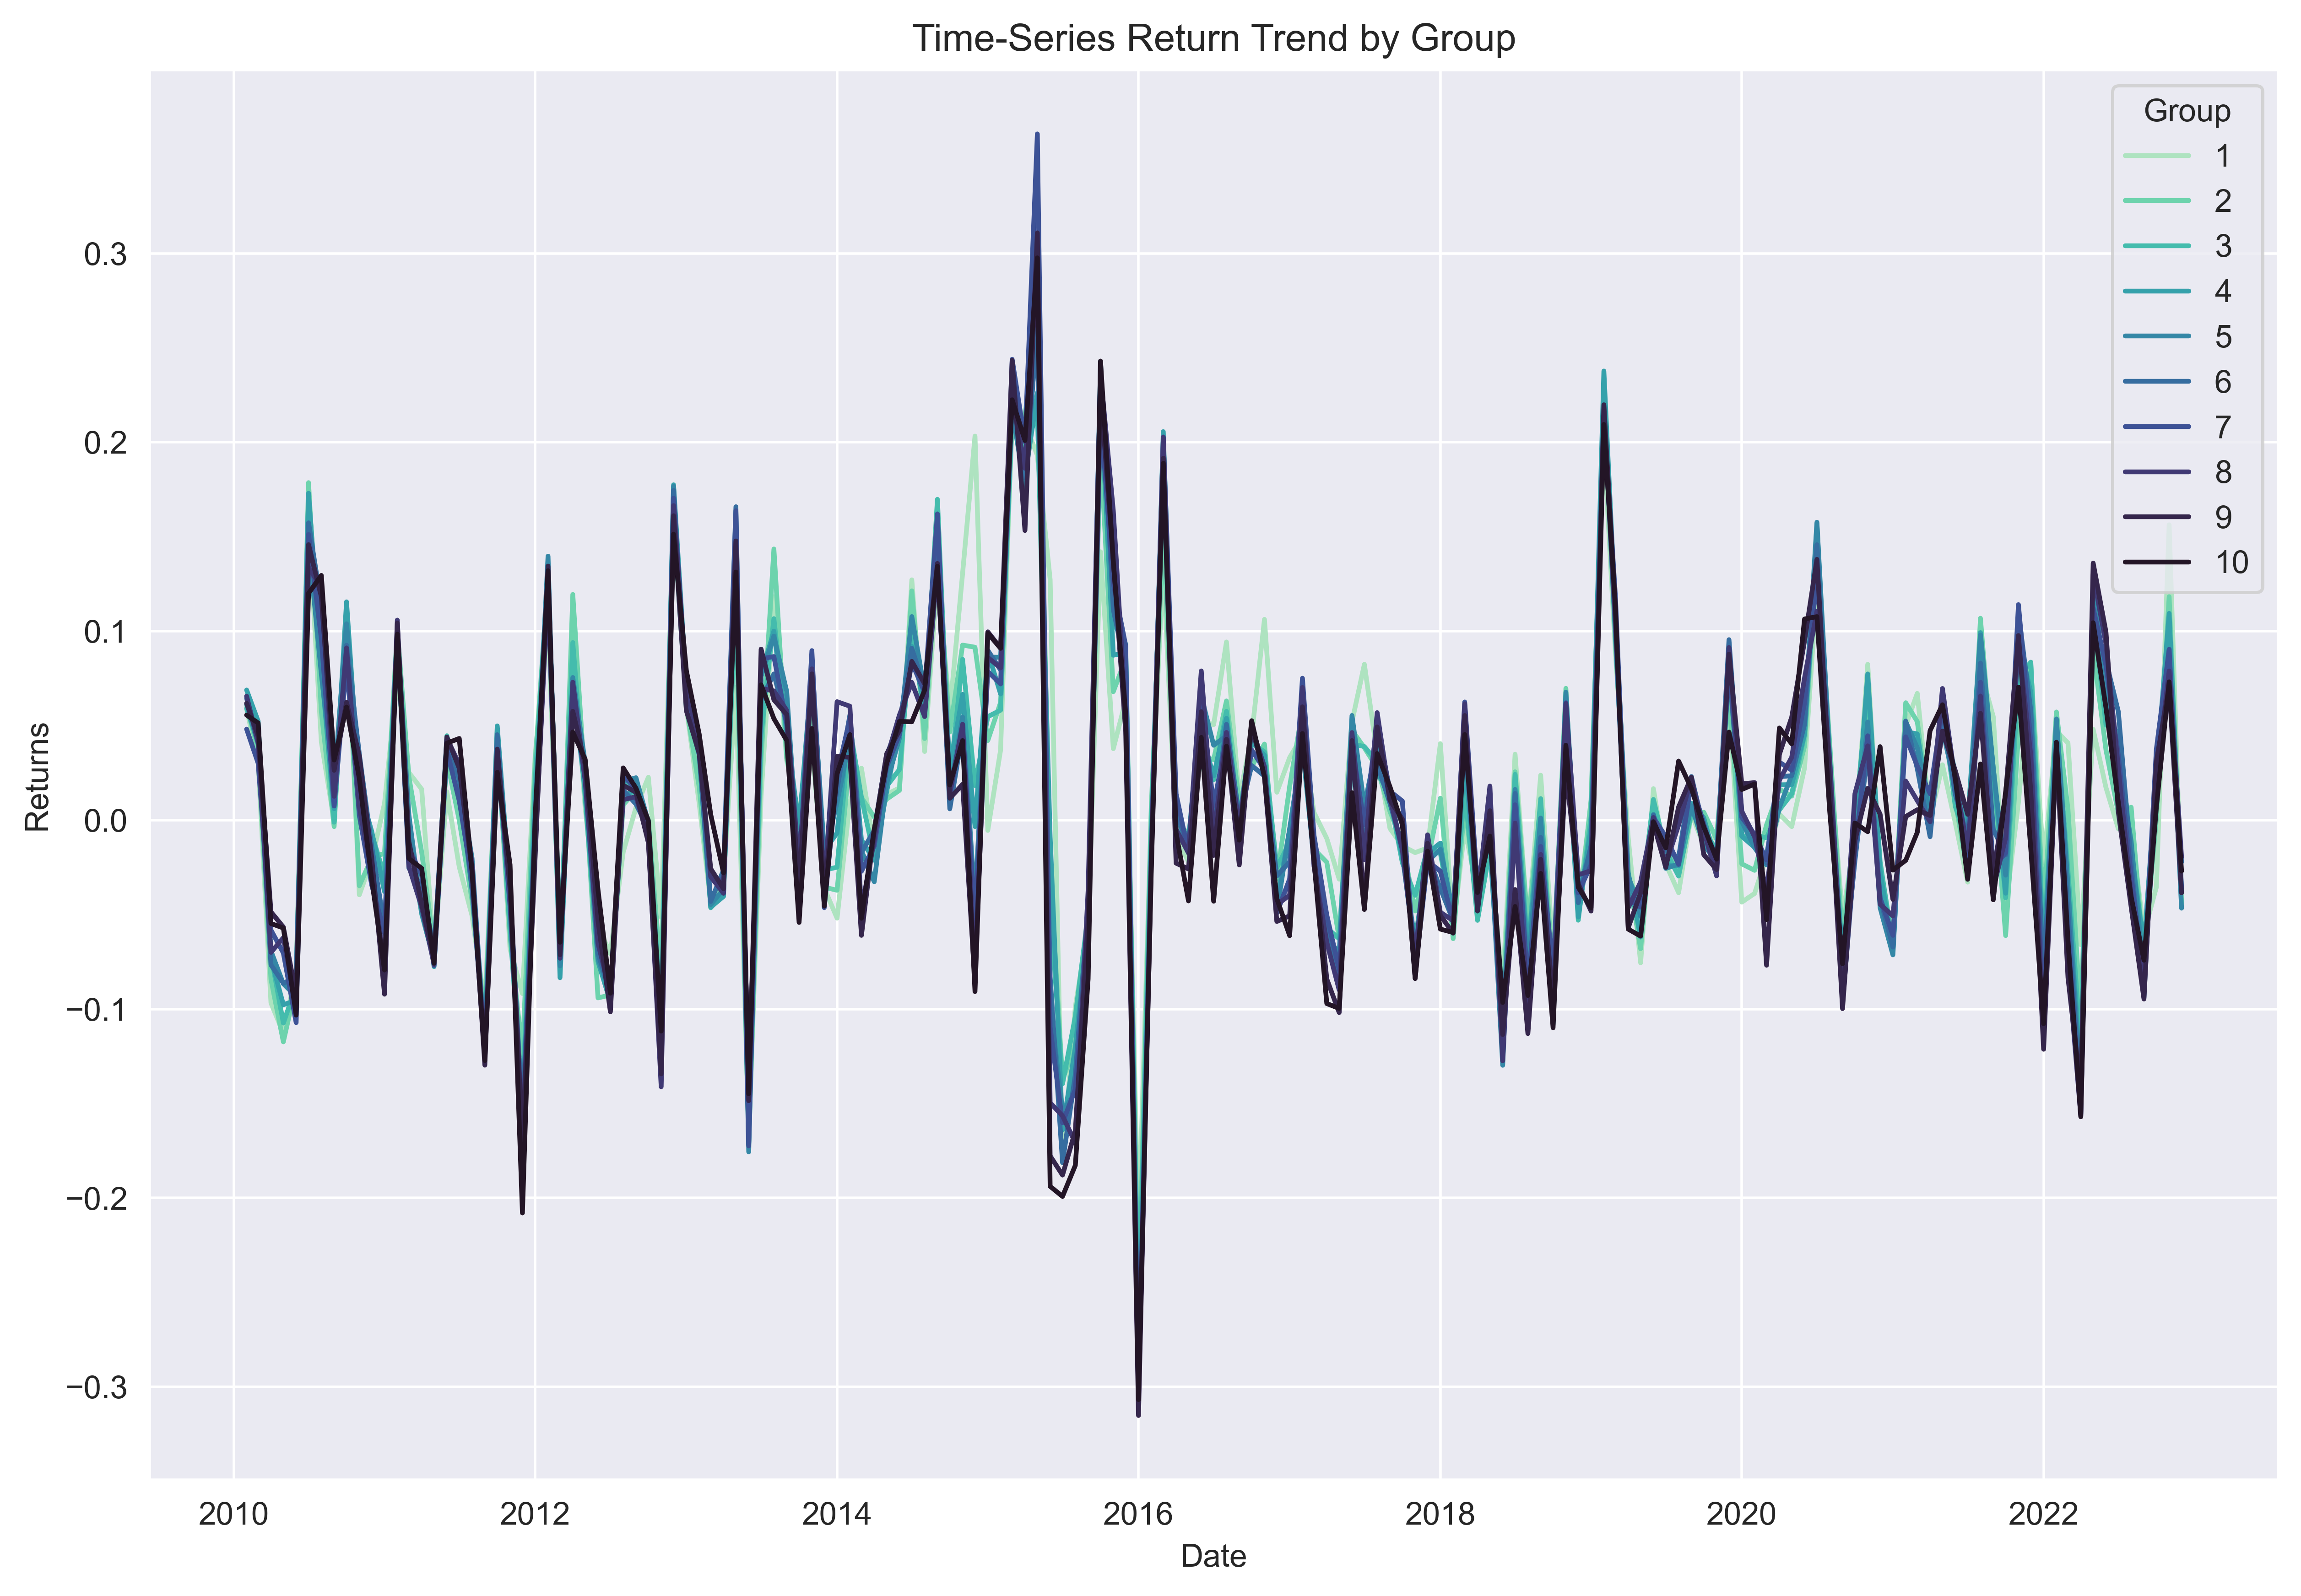

In [242]:
plt.figure(figsize=(12, 8), dpi = 500)
palette = sns.color_palette("mako_r", 10)
sns.set_style("darkgrid")
melted["Date"] = pd.to_datetime(melted["Date"].astype(str))
sns.lineplot(x = 'Date', y = 'Return', hue = 'Group', data = melted, palette = palette)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Time-Series Return Trend by Group')
plt.show()

### 2-2-2. Plot monthly cumulative returns

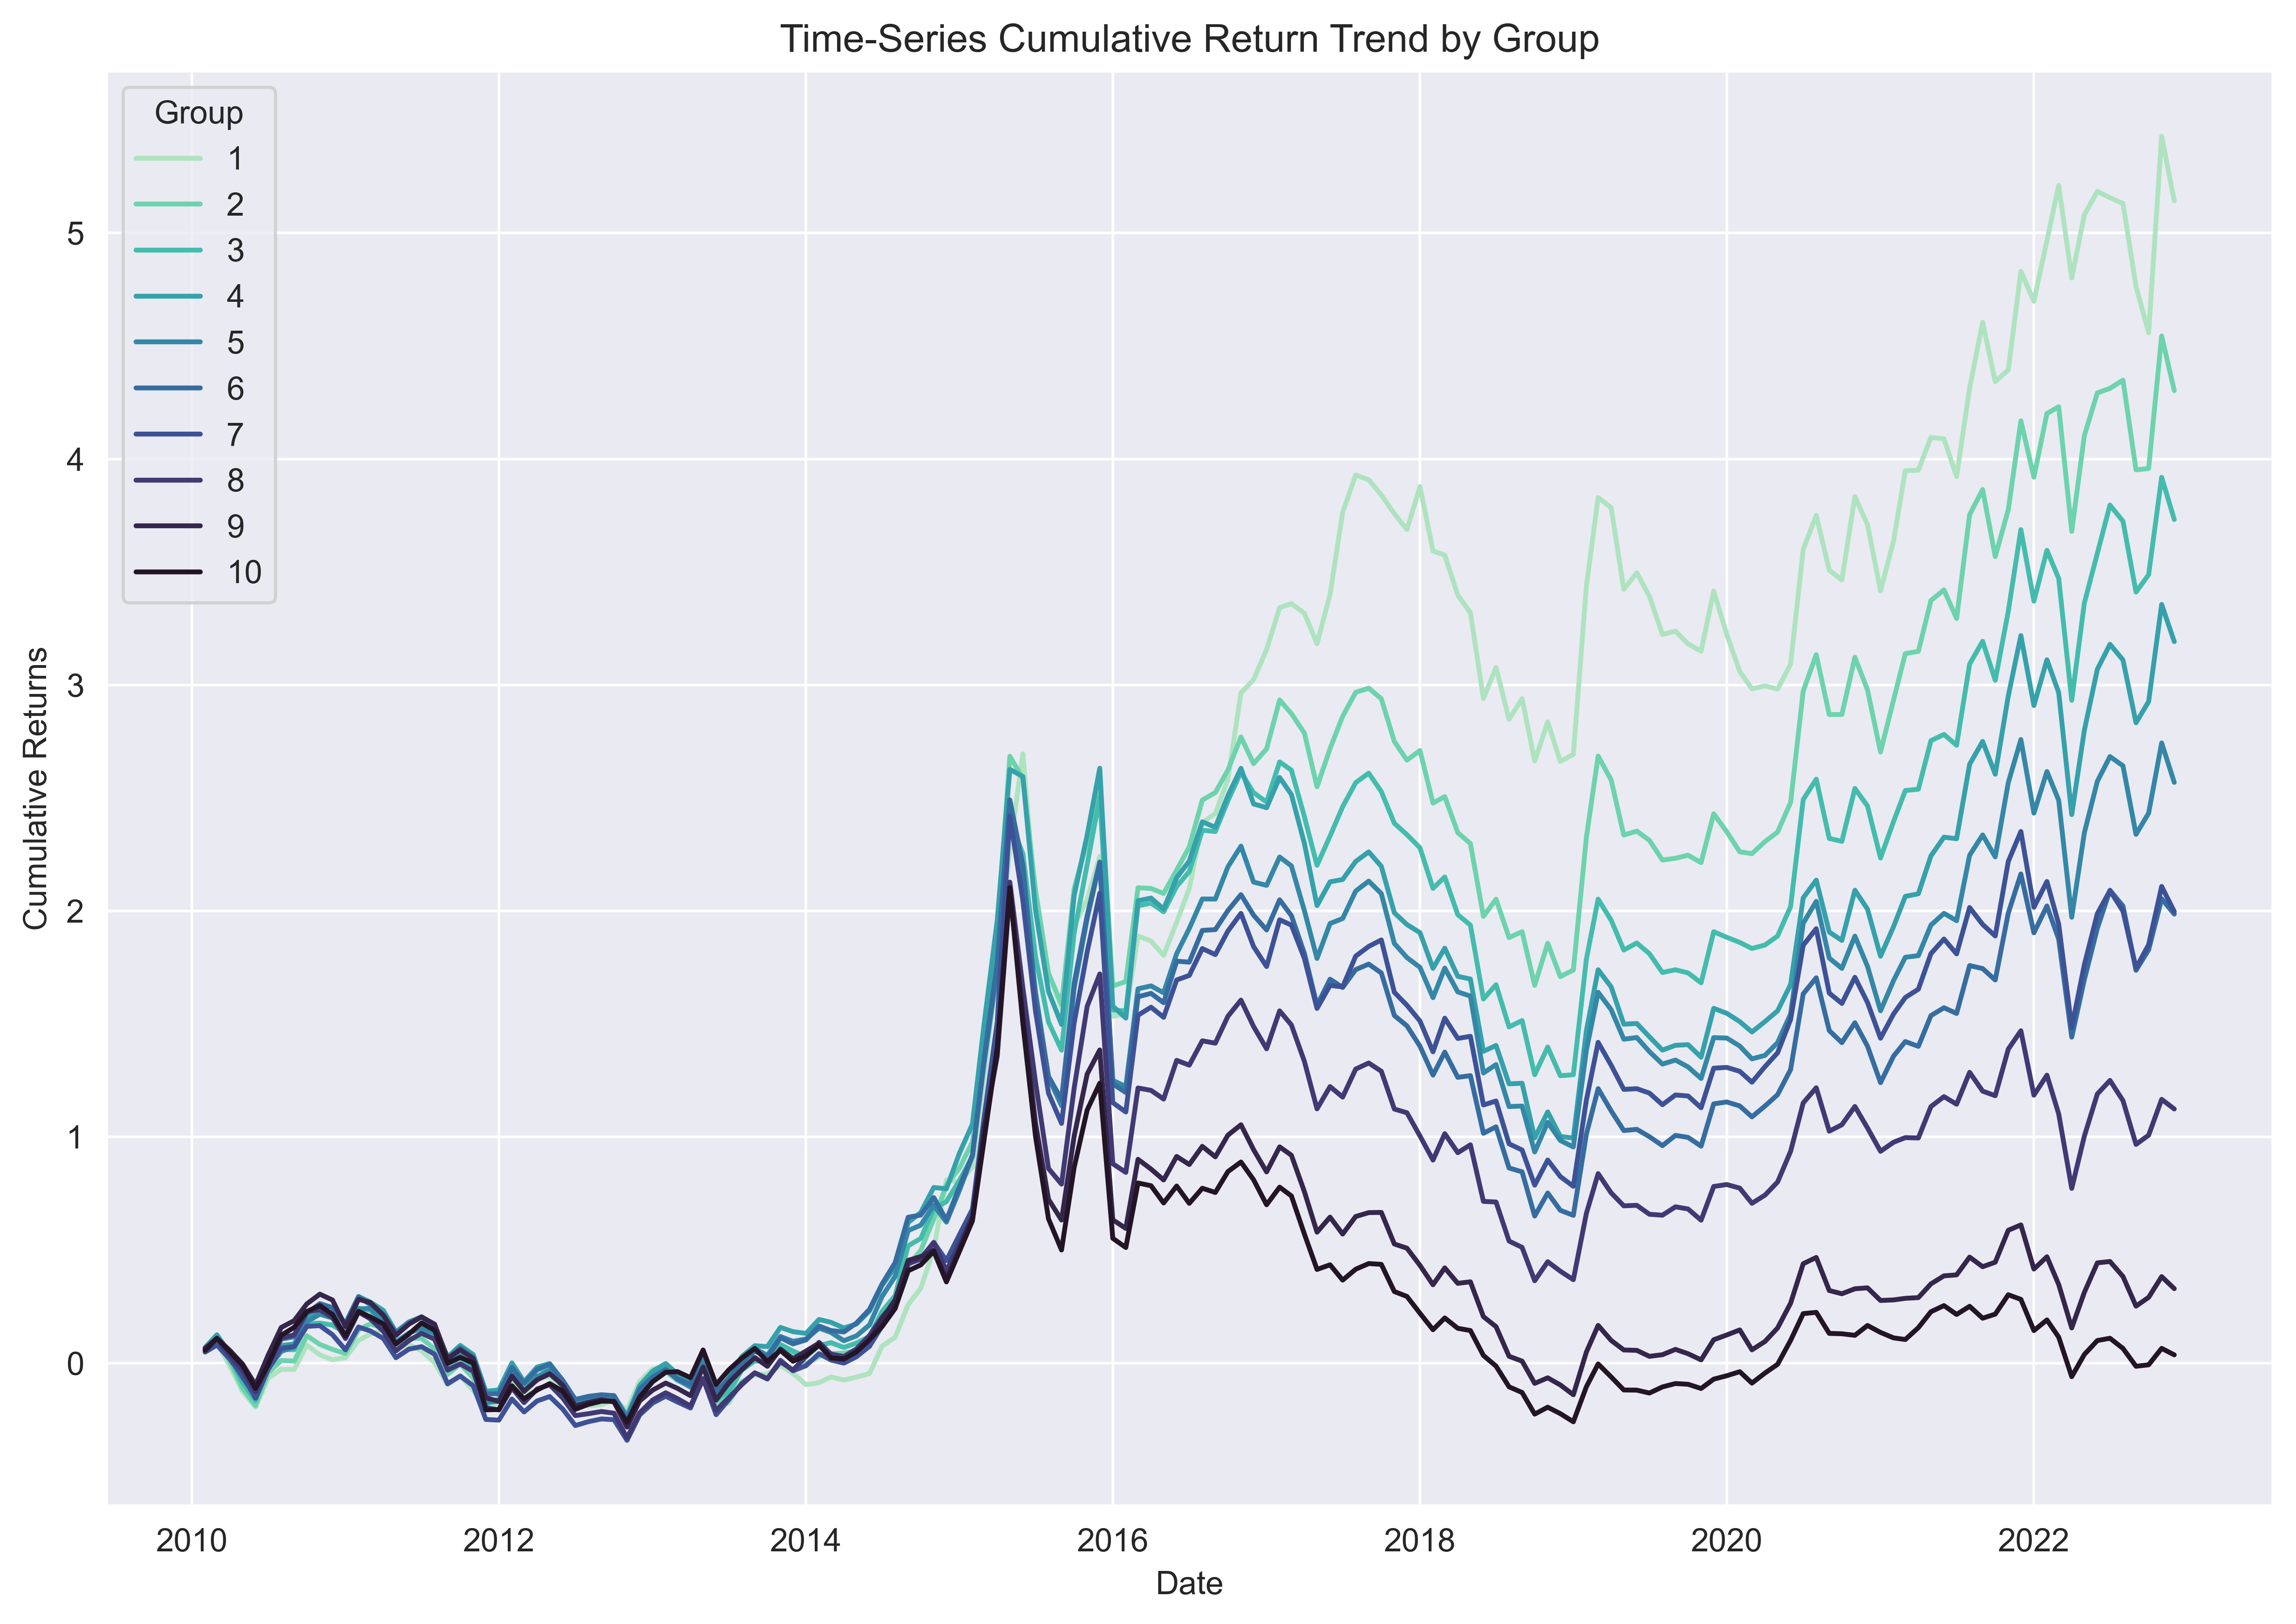

In [243]:
plt.figure(figsize=(12, 8), dpi = 500)
palette = sns.color_palette("mako_r", 10)
sns.set_style("darkgrid")
sns.lineplot(x = 'Date', y = 'Cum Return', hue = 'Group', data = melted, palette = palette)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Time-Series Cumulative Return Trend by Group')
plt.show()

### 2-3. Problem 2-3: Discuss my findings

**Finding 1**
- ***Observation***: Group 10(Largest last P/B Ratio)'s monthly return is much more volatile than Group 1(Smallest last P/B Ratio).
- ***Analysis***: 
    - Higher the P/B Ratio, the firm is more likely to be High-Tech company, which has more volatile cash flow, which makes the return more volatile.
    - Higher the P/B Ratio, the firm is more likely to be High-Tech company, which attract some speculators, which makes the return more volatile.

**Finding 2**
- ***Observation***: Starting from 2014, most of the groups have positive cumulative return. 
- ***Analysis***: 
    - Although there exists some risks in the Chinese Stock Market, most of the stocks possess positive returns.

**Finding 3**
- ***Observation***: Starting from 2016, the group with lower P/B Ratio has higher cumulative return.
- ***Analysis***: 
    - Lower the P/B Ratio, the firm is more likely to be a mature and stable one, which may create more stable and consistent return.

## 3. Acknowledgement
- Thanks for ***Professor Jinfan ZHANG*** and ***Teaching Assistants*** for designing this assignment.
- Thanks for ***Teaching Assistants*** and ***Undergraduate Student Teaching Fellows*** for reviewing and grading this submission.

Thank you so much!